In [ ]:
# !pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0 -q

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Requiero Mesa > 3.0.3
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
from mesa import Agent, Model

# Debido a que puede existir más de un solo agente por celda, haremos uso de ''MultiGrid''.
from mesa.space import MultiGrid

# Con 'BaseScheduler', los agentes se activan de forma secuencial en el orden que fueron agregados.
from mesa.time import BaseScheduler

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


In [ ]:
class TacoRescueAgent(Agent):
  def __init__(self, model):
    super().__init__(model)
    self.AP = 0
    self.carrying_victim = False

  def refill_ap(self):
    self.AP += 4
    if self.AP > 8:
      self.AP = 8

  def can_spend(self, cost):
    return self.AP >= cost
  
  def spend_AP(self, cost):
    if self.AP >= cost:
      self.AP -= cost
      return True
    return False
  
  def space_state(self, pos):
    # 0: Vacío | 1 = Humo | 2 = Fuego
    x, y = pos
    return int(self.model.fire[x][y])
  
  def neighbors(self):
    x, y = self.pos
    return self.model.grid.get_neighborhood((x, y), moore=False, include_center=False)
  
  def can_move_between(self, from_pos, to_pos):
    fx, fy = from_pos
    tx, ty = to_pos
    return self.model.can_propagate(fx, fy, tx, ty)
  
  def remove_smoke(self, pos):
    # Quitar humo: 1AP
    if self.space_state(pos) != 1:
      return False
    
    if self.spend_AP(1):
      x, y = pos
      self.model.fire[x][y] = 0
      return True
  
    return False
  
  def extinguish_fire(self, pos):
    if self.space_state(pos) != 2:
      return False
    
    if self.spend_AP(2):
      x, y = pos
      self.model.fire[x][y] = 0
      return True
    return False
  
  def pick_up_victim(self, pos):
    if self.carrying_victim:
      return False
    
    if pos in self.model.victims:
      return False
    
    if pos in self.model.entries and self.space_state(self.pos) != 2:
      self.carrying_victim = False
      self.model.rescued_count += 1
      return True
    
    return False
  
  def is_door_between(self, target_pos):
    return (self.pos in self.model.doors and self.model.doors[self.pos] == target_pos)
  
  def is_door_closed(self, target_pos):
    if not self.is_door_between(self.pos, target_pos):
      return False
    
    x1, y1 = self.pos
    x2, y2 = target_pos
    dx, dy = x2 - x1, y2 - y1

    if dx == 1:
      wall = 1
    elif dx == -1:
      wall = 3
    elif dy == 1:
      wall = 0
    elif dy == -1:
      wall = 2
    else:
      return False
    
    return self.walls[y1][x1][wall] == 1
  
  def is_wall_between(self, target_pos):
    x1, y1 = self.pos
    x2, y2 = target_pos
    dx, dy = x2 - x1, y2 - y1

    if dx == 1: 
      wall = 1 
    elif dx == -1: 
      wall = 3
    elif dy == 1: 
      wall = 0
    elif dy == -1: 
      wall = 2
    else: 
      return False

    return self.walls[y1][x1][wall] == 1

  def open_door(self, target_pos):
    if not self.is_door_between(self.pos, target_pos):
      return
    
    x1, y1 = self.pos
    x2, y2 = target_pos
    dx, dy = x2 - x1, y2 - y1

    if dx == 1:
      wall = 1
      opp = 3
    elif dx == -1:
      wall = 3
      opp = 1
    elif dy == 1:
      wall = 0
      opp = 2
    elif dy == -1:
      wall = 2
      opp = 0
    else:
      return
    
    self.walls[y1][x1][wall] = 0
    self.walls[y2][x2][opp] = 0

  def damage_wall(self, pos1, pos2):
    if not self.is_wall_between(pos1, pos2):
      return
    
    x1, y1 = pos1
    x2, y2 = pos2
    dx, dy = x2 - x1, y2 - y1

    if dx == 1:
      wall = 1
      opp = 3
    elif dx == -1:
      wall = 3
      opp = 1
    elif dy == 1:
      wall = 0
      opp = 2
    elif dy == -1:
      wall = 2
      opp = 0
    else:
      return
    
    # Si es una pared: acumula daño (2 golpes -> se destruye)
    if self.walls[y1][x1][wall] == 1:
      self.walls_damage[x1][y1][wall] += 1
      if self.walls_damage[x1][y1][wall] == 2:
        self.walls[y1][x1][wall] = 0

    # También daña la pared opuesta en la celda vecina
    if 0 <= x2 < self.grid.width and 0 <= x2 < self.grid.height:
      if self.walls[y2][x2][opp] == 1:
        self.walls_damage[x2][y2][opp] += 1
        if self.walls_damage[x2][y2][opp] >= 2:
          self.walls[y2][x2][opp] = 0
    
  # Para cacular el costo según las reglas
  def calculate_cost(self, target_pos):
    spaceState = self.space_state(target_pos)
    if self.carrying_victim:
      # Fuego
      if spaceState == 2:
        return None
      return 2
    else:
      # Fuego
      if spaceState == 2:
        return 2
      # Vacío o con humo
      return 1
    
  
    
  def try_move(self, target_pos):
    if not self.can_move_between(self.pos, target_pos):
      return False
    
    cost = self.calculate_cost(target_pos)
    # Al fuego cuando el agente tenga víctima cargada
    if cost is None:
      return False
    
    spaceState = self.space_state(target_pos)
    # Si es fuego
    if spaceState == 2:
      # El agente debe tener al menos 1 AP
      # Para poder convertirlo en humo
      if self.AP < cost + 1:
        return False
    
    # Paredes
    if self.is_wall_between(target_pos):
      if self.AP >= 2:
        self.damage_wall(target_pos[0] - self.pos[0], target_pos[1] - self.pos[1])
        self.AP -= 2
      # El agente todavía no se mueve
      return False
    
    # Puertas
    if self.is_door_between(target_pos):
      if self.is_door_closed(target_pos):
        if self.AP >= 1:
          self.open_door(target_pos)
          self.AP -= 1
        # El agente todavía no se mueve
        return False


    if not self.can_spend(cost):
      return False
    
    if not self.model.grid.is_cell_empty(target_pos):
      return False
    
    # Si no tiene restricciones, mueve hacia al target posición
    self.model.grid.move_agent(self, target_pos)

    return True
  
  # Busca la entrada cercana
  def nearest_entry(self):
    x, y = self.pos
    best = None
    best_dis = None
    for ix, iy in self.model.entries:
      d = abs(ix - x) + abs(iy - y)
      if best is None or d < best_dis:
        best = (ix, iy)
        best_dis = d
    return best
  
  def knock_out(self):
    self.pos = self.nearest_entry()
    return True
  
  def step(self):
    # += 4AP
    self.refill_ap()
    # Si el agente está en fuego
    if self.space_state(self.pos) == 2:
      self.knock_out()
      return
    
    possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    options = np.random.permutation(len(possible_positions))

    for i in options:
        pos = possible_positions[i]
        state = self.space_state(pos)

        if not self.try_move(pos):
          break        

  def step(self):
      self.AP += 4
      # Máximo AP => 8
      if self.AP > 8:
        AP = 8
      
      (x, y) = self.pos
      self.move()

In [4]:
# Función que genera una matriz RGB para visualizar el estado actual del tablero
# Blanco: Vacío | Gris: Humo | Rojo: Fuego
def get_grid(model):
    width, height = model.grid.width, model.grid.height
    grid = np.ones((width, height, 3))

    COLOR_FIRE = [1, 0, 0]        # Rojo
    COLOR_SMOKE = [0.5, 0.5, 0.5] # Gris

    # Fuego y Humo
    for x in range(width):
      for y in range(height):
        if model.fire[x][y] == 2:
          grid[x, y] = COLOR_FIRE
        elif model.fire[x][y] == 1:
          grid[x, y] = COLOR_SMOKE

    return grid

# Función que dibuja las paredes de cada celda en los ejes del grid
def draw_walls(ax, walls, walls_damage):
  height, width, _ = walls.shape
  for y in range(height):
    for x in range(width):
      cell = walls[y, x]
      damage = walls_damage[x, y]

      x0, y0 = x - 0.5, y - 0.5
      x1, y1 = x + 0.5, y + 0.5

      # Arriba
      if cell[0] == 1:
        if damage[0] == 0:
          ax.plot([x0, x1], [y1, y1], color="black", linewidth=2)
        elif damage[0] == 1:
          ax.plot([x0, x1], [y1, y1], color="orange", linewidth=2, linestyle="--")

      # Derecha
      if cell[1] == 1:
        if damage[1] == 0:
          ax.plot([x1, x1], [y0, y1], color="black", linewidth=2)
        elif damage[1] == 1:
          ax.plot([x1, x1], [y0, y1], color="orange", linewidth=2, linestyle="--")

      # Abajo
      if cell[2] == 1:
        if damage[2] == 0:
          ax.plot([x0, x1], [y0, y0], color="black", linewidth=2)
        elif damage[2] == 1:
            ax.plot([x0, x1], [y0, y0], color="orange", linewidth=2, linestyle="--")

      # Izquierda
      if cell[3] == 1:
        if damage[3] == 0:
          ax.plot([x0, x0], [y0, y1], color="black", linewidth=2)
        elif damage[3] == 1:
          ax.plot([x0, x0], [y0, y1], color="orange", linewidth=2, linestyle="--")

In [ ]:
class TacoRescueModel(Model):
  def __init__(self, width=8, height=6, players=6):
    super().__init__()

    self.grid = MultiGrid(width, height, torus=False)
    self.schedule = BaseScheduler(self)
    self.datacollector = DataCollector(model_reporters=
        {"Grid":get_grid,
        "Walls": lambda model: np.copy(model.walls),
        "WallsDamage": lambda model: np.copy(model.walls_damage),
        "Steps": lambda model: model.steps})

    self.steps = 0

    self.rescued_count = 0
    self.victims = [(3,4), (7,1)]
    self.false_alarms = [(0,1)]
    # Conjunto de POIs no-identificados actualmente en el tablero (face-down)
    # Estos cuentan para mantener siempre 3 POIs (victims + no-identificados)
    self.poi_unknown = set()
    self.fire_pos = [(1,4),(1,3),(2,4),(2,3),(3,3),(3,2),(4,3),(5,1),(5,0),(6,1)]
    self.entries = [(5,5),(0,3),(7,2),(2,0)]
    self.doors_pos = [(1,3,2,3),(2,5,3,5),(3,2,3,1),(4,4,5,6),(4,0,5,0),(5,2,6,2),(6,0,7,0),(7,4,7,3)]

    # Diccionario que almacena información de las puertas
    # Cada puerta conecta dos celdas, se registran en ambos sentidos
    self.doors = {}
    for (x1, y1, x2, y2) in self.doors_pos:
        self.doors[(x1, y1)] = (x2, y2)
        self.doors[(x2, y2)] = (x1, y1)

    # Cada celda tiene un array de 4 paredes: [arriba, derecha, abajo, izquierda]
    # 0: No hay pared / puerta abierta | 1: Si hay pared / puerta cerrada
    self.walls = np.array([
      [[0,0,1,1],[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,1,1,0],[0,0,1,1],[0,1,1,0],[0,1,1,1]],
      [[1,0,0,1],[1,0,0,0],[1,0,0,0],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0],[1,1,0,1]],
      [[0,0,1,1],[0,1,1,0],[0,0,1,1],[0,0,1,0],[0,0,1,0],[0,1,1,0],[0,0,1,1],[0,1,1,0]],
      [[0,0,0,1],[0,1,0,0],[1,0,0,1],[1,0,0,0],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0]],
      [[0,0,0,1],[0,0,0,0],[0,1,1,0],[0,0,1,1],[0,1,1,0],[0,0,1,1],[0,0,1,0],[0,1,1,0]],
      [[1,0,0,1],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0],[1,0,0,1],[1,0,0,0],[1,1,0,0]]])

    # Matriz que almacena daño acumulado en paredes
    self.walls_damage = np.zeros( (width, height, 4) )

    # Matriz que almacena el estado del fuego
    # 0: Vacío | 1 = Humo | 2 = Fuego
    self.fire = np.zeros( (width, height) )
    for (x, y) in self.fire_pos:
      self.fire[x][y] = 2

    # Colocar agentes en las entradas del tablero
    i = 0
    while (i < players):
      position = self.entries[i % len(self.entries)]
      agent = TacoRescueAgent(self)
      self.grid.place_agent(agent, position)
      self.schedule.add(agent)
      i += 1

  # Método que avanza el fuego según las reglas del juego
  def advance_fire(self):
    x = self.random.randrange(self.grid.width)
    y = self.random.randrange(self.grid.height)
    current = self.fire[x][y]

    # Si está vacío -> poner humo
    if current == 0:
      self.fire[x][y] = 1
      if self.is_adjacent_to_fire(x, y):
          self.fire[x][y] = 2

    # Si hay humo -> convertir en fuego
    elif current == 1:
        self.fire[x][y] = 2

    # Si hay fuego -> explosión
    elif current == 2:
        self.explosion(x, y)

    # Aplicar flashover después de cada avance
    self.flashover()

  # Método que verifica si una celda es adyacente a fuego
  def is_adjacent_to_fire(self, x, y):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if self.can_propagate(x, y, nx, ny):
            if self.fire[nx][ny] == 2:
                return True
    return False

  # Método que verifica si se puede propagar fuego entre dos celdas
  def can_propagate(self, x, y, nx, ny):
    if not (0 <= nx < self.grid.width and 0 <= ny < self.grid.height):
      return False

    dx, dy = nx - x, ny - y

    # Arriba
    if dx == 0 and dy == 1:
      if self.walls[y][x][0] == 1:
        return False

    # Abajo
    if dx == 0 and dy == -1:
      if self.walls[y][x][2] == 1:
        return False

    # Derecha
    if dx == 1 and dy == 0:
      if self.walls[y][x][1] == 1:
        return False

    # Izquierda
    if dx == -1 and dy == 0:
      if self.walls[y][x][3] == 1:
        return False

    return True

  # Método que maneja una explosión: propaga fuego y daña paredes
  def explosion(self, x, y):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dx, dy in directions:
      nx, ny = x + dx, y + dy
      self.damage_wall(x, y, dx, dy)
      if self.can_propagate(x, y, nx, ny):
        self.shockwave(nx, ny, dx, dy)

  # Método que propaga la onda expansiva en línea recta
  def shockwave(self, x, y, dx, dy):
    while 0 <= x < self.grid.width and 0 <= y < self.grid.height:
      prev_x, prev_y = x - dx, y - dy
      if not self.can_propagate(prev_x, prev_y, x, y):
        break

      # Si encuentra vacío o humo, lo convierte en fuego y se detiene
      if self.fire[x][y] == 0 or self.fire[x][y] == 1:
          self.fire[x][y] = 2
          break

      # Si hay fuego, continua la onda expansiva
      elif self.fire[x][y] == 2:
          self.damage_wall(x, y, dx, dy)
          x += dx
          y += dy

  # Método que aplica el flashover: humo adyacente a fuego -> fuego
  def flashover(self):
    for y in range(self.grid.height):
      for x in range(self.grid.width):
        if self.fire[x][y] == 1 and self.is_adjacent_to_fire(x, y):
          self.fire[x][y] = 2

  # Método que daña paredes y puertas entre dos celdas
  def damage_wall(self, x, y, dx, dy):

    # Arriba
    if dx == 0 and dy == 1:
      wall = 0
      opp_wall = 2
      nx, ny = x, y + 1

    # Abajo
    elif dx == 0 and dy == -1:
      wall = 2
      opp_wall = 0
      nx, ny = x, y - 1

    # Derecha
    elif dx == 1 and dy == 0:
      wall = 1
      opp_wall = 3
      nx, ny = x + 1, y

    # Izquierda
    elif dx == -1 and dy == 0:
      wall = 3
      opp_wall = 1
      nx, ny = x - 1, y

    # Si es una puerta: romper inmediatamente
    if (x, y) in self.doors and self.doors[(x, y)] == (nx, ny):
      if self.walls[y][x][wall] == 1:
        self.walls[y][x][wall] = 0
        self.walls[ny][nx][opp_wall] = 0
        del self.doors[(x, y)]
        del self.doors[(nx, ny)]
      return

    # Si es una pared: acumula daño (2 golpes -> se destruye)
    if self.walls[y][x][wall] == 1:
      self.walls_damage[x][y][wall] += 1
      if self.walls_damage[x][y][wall] == 2:
        self.walls[y][x][wall] = 0

    # También daña la pared opuesta en la celda vecina
    if 0 <= nx < self.grid.width and 0 <= ny < self.grid.height:
      if self.walls[ny][nx][opp_wall] == 1:
        self.walls_damage[nx][ny][opp_wall] += 1
        if self.walls_damage[nx][ny][opp_wall] >= 2:
          self.walls[ny][nx][opp_wall] = 0

  # --- Replenish POI (Step 3) ---
  def _has_firefighter(self, x, y):
    """Devuelve True si hay un agente bombero en (x, y)."""
    agents_here = self.grid.get_cell_list_contents([(x, y)])
    return any(isinstance(a, TacoRescueAgent) for a in agents_here)

  def _reveal_poi(self, x, y):
    """
    Revela un POI si se coloca donde hay un bombero.
    Probabilidades: 75% Víctima, 25% Falsa Alarma.
    Si resulta Falsa Alarma, no permanece en el tablero.
    """
    if self.random.random() < 0.25:
      # Falsa alarma: registrar y remover
      self.false_alarms.append((x, y))
      return "false_alarm"
    else:
      # Víctima: queda revelada
      self.victims.append((x, y))
      return "victim"

  def replenish_poi(self):
    """
    Al final del turno, asegurar que existan 3 POIs en el tablero
    (suma de Víctimas reveladas + POIs no-identificados).
    Reglas:
    - Colocar POI boca abajo en casilla objetivo aleatoria (repetir si ya hay POI).
    - Si hay Fuego/Humo en el objetivo, retirarlo antes de colocar el POI.
    - Si hay un Bombero en el objetivo, revelar de inmediato y retirar si es Falsa Alarma.
    """
    while (len(self.victims) + len(self.poi_unknown)) < 3:
      # Selección de objetivo (provisional): casilla aleatoria uniforme.
      # Más adelante podremos reemplazar esto con el mapeo de dados oficial.
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)

      # Repetir si hay ya un POI (víctima conocida o no-identificado)
      if (x, y) in self.victims or (x, y) in self.poi_unknown:
        continue

      # Quitar humo/fuego previo a colocar el POI
      if self.fire[x][y] in (1, 2):
        self.fire[x][y] = 0

      # Si hay un bombero, revelar de inmediato
      if self._has_firefighter(x, y):
        self._reveal_poi(x, y)
        # Si fue falsa alarma, no cuenta; si fue víctima, ya sumó en self.victims
        continue

      # Colocar POI no-identificado
      self.poi_unknown.add((x, y))

  # Método que ejecuta un paso del modelo
  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()
    self.advance_fire()
    # Paso 3: Reponer POIs al final del turno
    self.replenish_poi()

In [26]:
model = TacoRescueModel()
while (model.steps < 50):
    model.step()

/var/folders/5c/pd3l4rms695cbdvzydjf0mwr0000gn/T/ipykernel_91645/4028748136.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = BaseScheduler(self)


AttributeError: 'TacoRescueAgent' object has no attribute 'move'

In [8]:
# Obtenemos la información que almacenó el colector
# Este nos entregará un DataFrame de pandas que contiene toda la información
all_grids = model.datacollector.get_model_vars_dataframe()
all_walls = model.datacollector.get_model_vars_dataframe()["Walls"]
all_walls_damage = model.datacollector.get_model_vars_dataframe()["WallsDamage"]

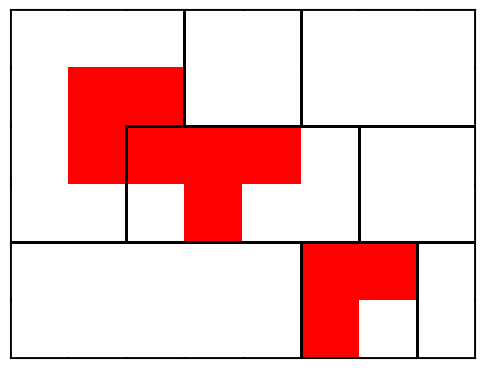

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
axs.set_xticks([])
axs.set_yticks([])

patch = axs.imshow(np.swapaxes(all_grids.iloc[0, 0], 0, 1), origin='lower')
draw_walls(axs, all_walls.iloc[0], all_walls_damage.iloc[0])

def animate(i):
    axs.clear()
    axs.imshow(np.swapaxes(all_grids.iloc[i, 0], 0, 1), origin='lower')
    draw_walls(axs, all_walls.iloc[i], all_walls_damage.iloc[i])
    axs.set_xticks([])
    axs.set_yticks([])

anim = animation.FuncAnimation(fig, animate, frames=len(all_grids))
plt.show()

In [ ]:
anim